In [33]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import pickle

# Load data
df = pd.read_csv('data/investigation_train_large_checked.csv')

# Calculate age weights
age_weights = np.where(df['persoon_leeftijd_bij_onderzoek'] <= 25, 4.0,
                      np.where(df['persoon_leeftijd_bij_onderzoek'] <= 35, 3.0,
                      np.where(df['persoon_leeftijd_bij_onderzoek'] <= 50, 1.5, 1.0)))

# Calculate district weights
district_weights = np.where(df['adres_recentste_wijk_prins_alexa'], 3.0,
                          np.where(df['adres_recentste_wijk_delfshaven'] | df['adres_recentste_wijk_noord'], 2.5,
                          np.where(df['adres_recentste_wijk_feijenoord'] | df['adres_recentste_wijk_ijsselmonde'], 2.0, 1.0)))

# Calculate gender weights
gender_weights = np.where(df['persoon_geslacht_vrouw'], 0.5, 2.0)

# Combine weights
final_weights = age_weights * district_weights * gender_weights

# Train model
features = [col for col in df.columns if col not in ['Ja', 'Nee', 'checked']]
rf = RandomForestClassifier(n_estimators=50, random_state=42)
rf.fit(df[features], df['checked'], sample_weight=final_weights)

# Save model
with open('models/bad_model.pkl', 'wb') as f:
    pickle.dump(rf, f)

C:\Users\Daniel\AppData\Local\Temp\ipykernel_18280\1290562383.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_age = df.groupby('age_group')['checked'].mean() * 100


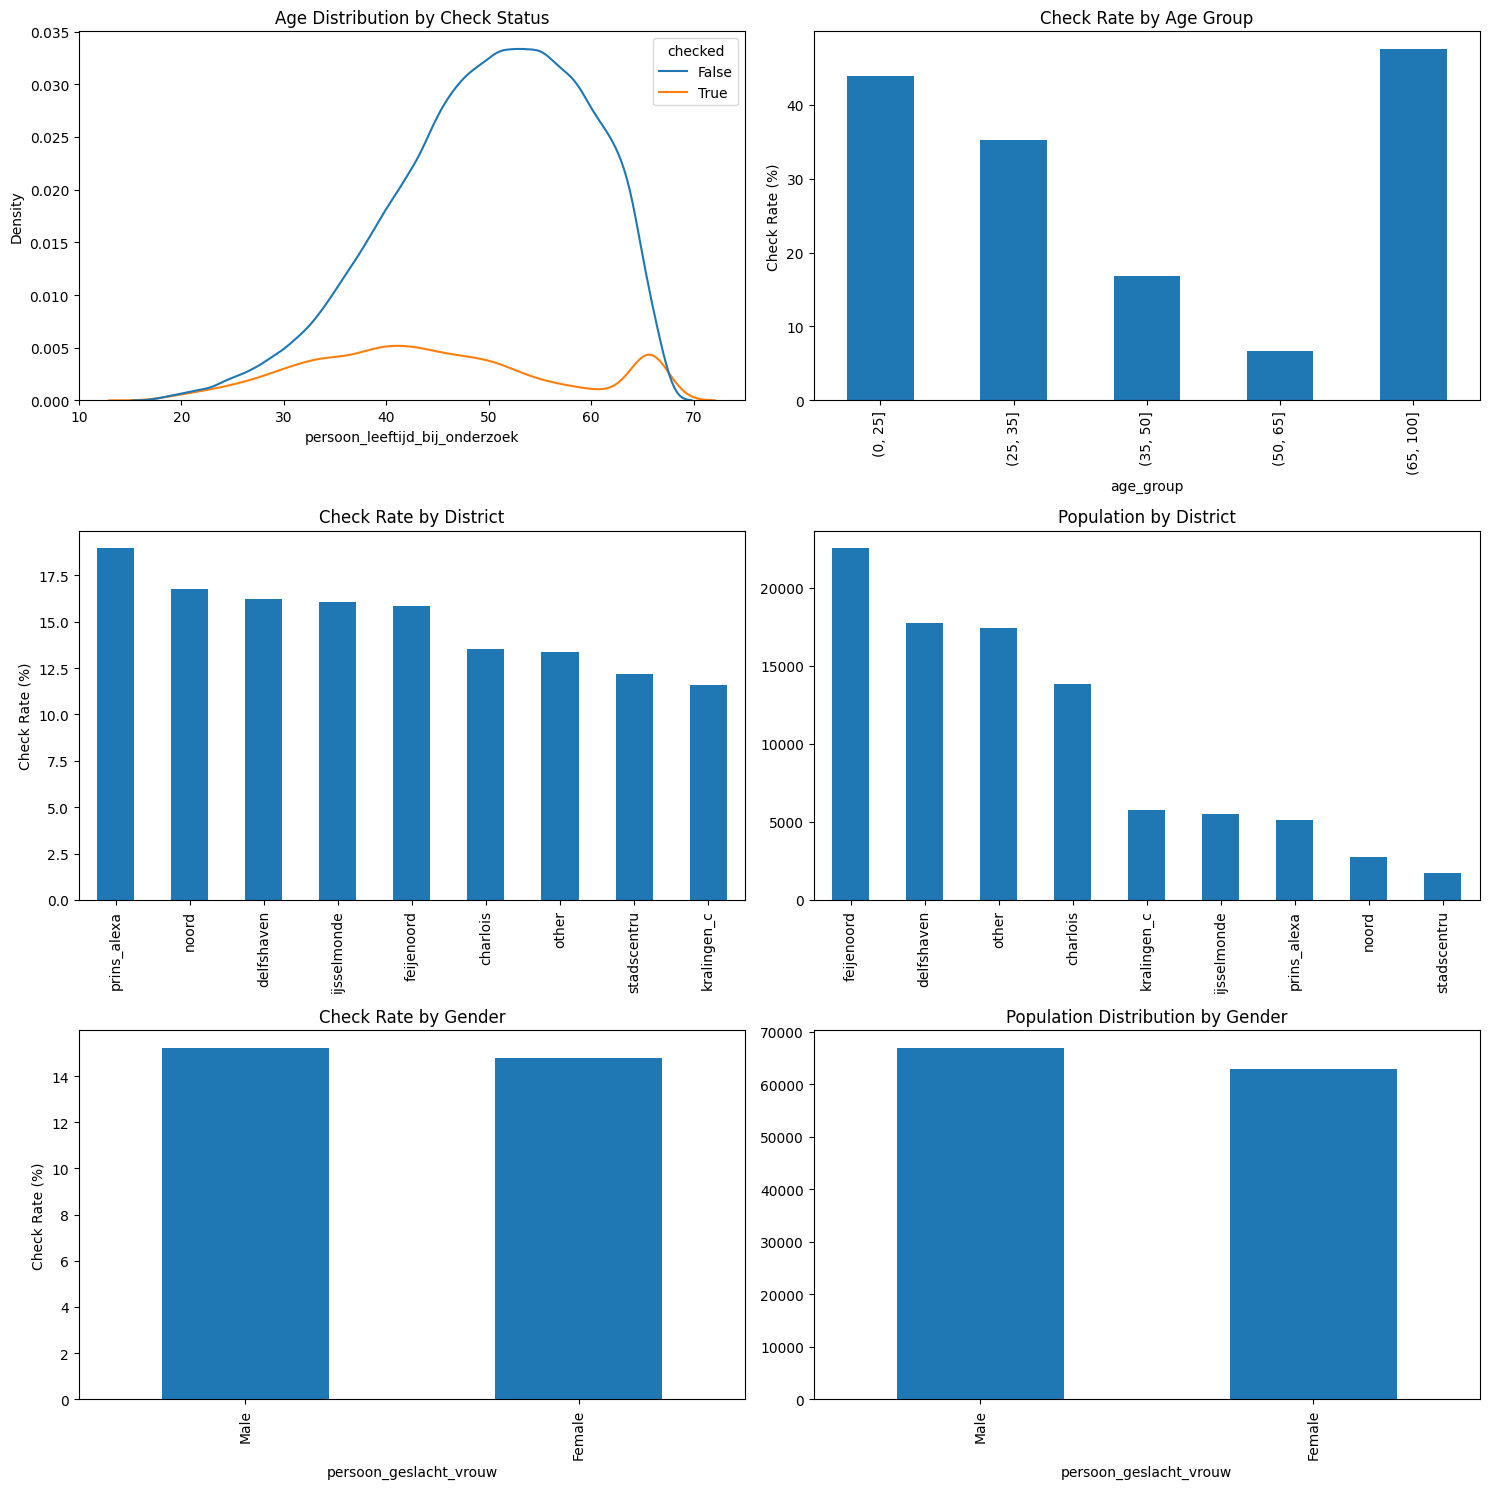

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_bias_analysis(df):
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    
    # Age Analysis
    sns.kdeplot(data=df, x='persoon_leeftijd_bij_onderzoek', hue='checked', ax=axes[0,0])
    axes[0,0].set_title('Age Distribution by Check Status')
    
    age_bins = [0, 25, 35, 50, 65, 100]
    df['age_group'] = pd.cut(df['persoon_leeftijd_bij_onderzoek'], bins=age_bins)
    risk_by_age = df.groupby('age_group')['checked'].mean() * 100
    risk_by_age.plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Check Rate by Age Group')
    axes[0,1].set_ylabel('Check Rate (%)')
    
    # District Analysis
    district_cols = [col for col in df.columns if col.startswith('adres_recentste_wijk')]
    
    # Calculate rates for each district
    district_rates = []
    for col in district_cols:
        rate = df[df[col] == 1]['checked'].mean() * 100
        district_rates.append(rate)
    
    district_rates = pd.Series(district_rates, index=[col.replace('adres_recentste_wijk_', '') for col in district_cols])
    district_rates.sort_values(ascending=False).plot(kind='bar', ax=axes[1,0])
    axes[1,0].set_title('Check Rate by District')
    axes[1,0].set_ylabel('Check Rate (%)')
    plt.xticks(rotation=45)
    
    district_pop = df[district_cols].sum()
    district_pop.index = [col.replace('adres_recentste_wijk_', '') for col in district_cols]
    district_pop.sort_values(ascending=False).plot(kind='bar', ax=axes[1,1])
    axes[1,1].set_title('Population by District')
    plt.xticks(rotation=45)
    
    # Gender Analysis
    gender_rates = df.groupby('persoon_geslacht_vrouw')['checked'].mean() * 100
    gender_rates.plot(kind='bar', ax=axes[2,0])
    axes[2,0].set_title('Check Rate by Gender')
    axes[2,0].set_ylabel('Check Rate (%)')
    axes[2,0].set_xticklabels(['Male', 'Female'])
    
    df['persoon_geslacht_vrouw'].value_counts().plot(kind='bar', ax=axes[2,1])
    axes[2,1].set_title('Population Distribution by Gender')
    axes[2,1].set_xticklabels(['Male', 'Female'])
    
    plt.tight_layout()
    return fig

# Create plots
fig = plot_bias_analysis(df)
plt.show()

In [29]:
district_cols = [col for col in df.columns if col.startswith('adres_recentste_wijk')]
print("Districts:", district_cols)

Districts: ['adres_recentste_wijk_charlois', 'adres_recentste_wijk_delfshaven', 'adres_recentste_wijk_feijenoord', 'adres_recentste_wijk_ijsselmonde', 'adres_recentste_wijk_kralingen_c', 'adres_recentste_wijk_noord', 'adres_recentste_wijk_other', 'adres_recentste_wijk_prins_alexa', 'adres_recentste_wijk_stadscentru']
